<a href="https://colab.research.google.com/github/shuhbam199/FebGithub/blob/main/Ola_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)
Tenure information (joining date, Last Date)
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
import shap
import xgboost as xgb

In [4]:
df = pd.read_csv('ola.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


null in lastworking date why ?

##EDA

In [110]:
df.isna().sum()/len(df)*100

,0
Unnamed: 0,0.000000
MMM-YY,0.000000
Driver_ID,0.000000
Age,0.319305
Gender,0.272194
City,0.000000
Education_Level,0.000000
Income,0.000000
Dateofjoining,0.000000
LastWorkingDate,91.541039


last working date indicates churn

In [103]:
df.groupby(['Driver_ID'])['Grade'].nunique().nlargest(5)

,Grade
Driver_ID,
26,2
54,2
60,2
98,2
275,2


change in grade over a period of time

In [102]:
df[df['Driver_ID'] == 26]

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn,Periods_served,Tenure
138,138,2019-01-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,243110,4,1,NaT,239.0
139,139,2019-02-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,646330,4,1,NaT,270.0
140,140,2019-03-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,17651940,4,1,NaT,298.0
141,141,2019-04-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,242510,4,1,NaT,329.0
142,142,2019-05-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,1098080,4,1,NaT,359.0
143,143,2019-06-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,1212720,4,1,NaT,390.0
144,144,2019-07-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,2695910,4,1,NaT,420.0
145,145,2019-08-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,494710,4,1,NaT,451.0
146,146,2019-09-01,26,42.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,986540,4,1,NaT,482.0
147,147,2019-10-01,26,42.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,9950710,4,1,NaT,512.0


In [6]:
from sklearn.impute import KNNImputer

In [8]:
df.select_dtypes(np.number)

,Unnamed: 0,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,1,28.0,0.0,2,57387,1,1,2381060,2
1,1,1,28.0,0.0,2,57387,1,1,-665480,2
2,2,1,28.0,0.0,2,57387,1,1,0,2
3,3,2,31.0,0.0,2,67016,2,2,0,1
4,4,2,31.0,0.0,2,67016,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...
19099,19099,2788,30.0,0.0,2,70254,2,2,740280,3
19100,19100,2788,30.0,0.0,2,70254,2,2,448370,3
19101,19101,2788,30.0,0.0,2,70254,2,2,0,2
19102,19102,2788,30.0,0.0,2,70254,2,2,200420,2


In [16]:
df.select_dtypes(include = ['object']).columns.values

array(['MMM-YY', 'City', 'Dateofjoining', 'LastWorkingDate'], dtype=object)

In [117]:
df.select_dtypes(include=['object'])

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,MMM-YY,City,Dateofjoining,LastWorkingDate
0,01/01/19,C23,24/12/18,NaN
1,02/01/19,C23,24/12/18,NaN
2,03/01/19,C23,24/12/18,03/11/19
3,11/01/20,C7,11/06/20,NaN
4,12/01/20,C7,11/06/20,NaN
...,...,...,...,...
19099,08/01/20,C27,06/08/20,NaN
19100,09/01/20,C27,06/08/20,NaN
19101,10/01/20,C27,06/08/20,NaN
19102,11/01/20,C27,06/08/20,NaN


In [20]:
df['City_encoded'] = df.groupby('City')['Grade'].transform('mean')
#encoding

In [21]:
df['City_encoded'] = np.round(df['City_encoded'],3)

In [22]:
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'], errors='coerce')
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
# converting to date type

In [23]:
df.groupby(['Driver_ID'])['Joining Designation'].nunique().nlargest(5)
#checking if joining designation is constant

,Joining Designation
Driver_ID,
1,1
2,1
4,1
5,1
6,1


##Filling null with KNN

In [24]:
from sklearn.impute import KNNImputer

In [31]:
KNN = KNNImputer(n_neighbors= 5, metric = 'nan_euclidean', weights = 'distance')

In [26]:
df2 = df.copy()

In [27]:
df2.drop('City', axis=1, inplace = True)

In [28]:
df2.drop('Unnamed: 0', axis = 1, inplace=True)

In [29]:
df3 = df2.select_dtypes(np.number)

In [32]:
df3_imputed =  pd.DataFrame(KNN.fit_transform(df3), columns = df3.columns)

In [33]:
df4 = df2.select_dtypes(exclude = [np.number])

In [34]:
df_new = pd.concat([df4, df3_imputed], axis =1)

In [35]:
df_new['Churn'] = df_new['LastWorkingDate'].notna().map({True:1, False:0})
##churn = 1, else 0

## Feature Engineering

In [36]:
df_new['Last_grade'] = df_new.groupby('Driver_ID')['Grade'].transform('last')

In [37]:
df_new['first_grade'] = df_new.groupby('Driver_ID')['Grade'].transform('first')

In [38]:
df_new['Last_des'] = df_new.groupby('Driver_ID')['Joining Designation'].transform('last')
df_new['first_des'] = df_new.groupby('Driver_ID')['Joining Designation'].transform('first')

In [39]:
df_new[df_new['Last_des'] != df_new['first_des']]

,MMM-YY,Dateofjoining,LastWorkingDate,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,City_encoded,Churn,Last_grade,first_grade,Last_des,first_des


means designation is same

In [40]:
df_new['Last_rat'] = df_new.groupby('Driver_ID')['Quarterly Rating'].transform('last')
df_new['first_rat'] = df_new.groupby('Driver_ID')['Quarterly Rating'].transform('first')
df_new[df_new['Last_rat'] != df_new['first_rat']]

,MMM-YY,Dateofjoining,LastWorkingDate,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,City_encoded,Churn,Last_grade,first_grade,Last_des,first_des,Last_rat,first_rat
13,2020-08-01,2020-07-31,NaT,6.0,31.0,1.0,1.0,78728.0,3.0,3.0,0.0,1.0,2.263,0,3.0,3.0,3.0,3.0,2.0,1.0
14,2020-09-01,2020-07-31,NaT,6.0,31.0,1.0,1.0,78728.0,3.0,3.0,0.0,1.0,2.263,0,3.0,3.0,3.0,3.0,2.0,1.0
15,2020-10-01,2020-07-31,NaT,6.0,31.0,1.0,1.0,78728.0,3.0,3.0,0.0,2.0,2.263,0,3.0,3.0,3.0,3.0,2.0,1.0
16,2020-11-01,2020-07-31,NaT,6.0,31.0,1.0,1.0,78728.0,3.0,3.0,1265000.0,2.0,2.263,0,3.0,3.0,3.0,3.0,2.0,1.0
17,2020-12-01,2020-07-31,NaT,6.0,31.0,1.0,1.0,78728.0,3.0,3.0,0.0,2.0,2.263,0,3.0,3.0,3.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2020-08-01,2020-06-08,NaT,2788.0,30.0,0.0,2.0,70254.0,2.0,2.0,740280.0,3.0,2.307,0,2.0,2.0,2.0,2.0,2.0,1.0
19100,2020-09-01,2020-06-08,NaT,2788.0,30.0,0.0,2.0,70254.0,2.0,2.0,448370.0,3.0,2.307,0,2.0,2.0,2.0,2.0,2.0,1.0
19101,2020-10-01,2020-06-08,NaT,2788.0,30.0,0.0,2.0,70254.0,2.0,2.0,0.0,2.0,2.307,0,2.0,2.0,2.0,2.0,2.0,1.0
19102,2020-11-01,2020-06-08,NaT,2788.0,30.0,0.0,2.0,70254.0,2.0,2.0,200420.0,2.0,2.307,0,2.0,2.0,2.0,2.0,2.0,1.0


In [41]:
df_new['Last_income'] = df_new.groupby('Driver_ID')['Income'].transform('last')
df_new['first_income'] = df_new.groupby('Driver_ID')['Income'].transform('first')
df_new['change_income'] = df_new['Last_income'] - df_new['first_income']

In [42]:
df_new.drop(['Last_income','first_income'], axis = 1, inplace = True)

In [43]:
df_new['change_income'].describe()

,change_income
count,19104.000000
mean,354.875890
std,1607.298464
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,12155.000000


In [44]:
df_new['Income_increased'] = np.where(df_new['change_income'] > 0.0, 1,0)

In [45]:
df_new['Grade_improved'] = np.where(df_new['Last_grade']- df_new['first_grade']> 0.0, 1,
                                    np.where(df_new['Last_grade']- df_new['first_grade']< 0.0, -1, 0))
df_new['Rate_improved'] = np.where(df_new['Last_rat']- df_new['first_rat']> 0.0, 1,
                                    np.where(df_new['Last_rat']- df_new['first_rat']< 0.0, -1, 0))

In [46]:
df_new['Rating_change'] = df_new['Last_rat']- df_new['first_rat']


In [47]:
df_new['Rating_change'].value_counts()

,count
Rating_change,
0.0,9140
-1.0,3369
1.0,2902
-2.0,1572
2.0,1075
-3.0,567
3.0,479


In [48]:
df_new[df_new['Rate_improved'] == -1]

,MMM-YY,Dateofjoining,LastWorkingDate,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,...,first_grade,Last_des,first_des,Last_rat,first_rat,change_income,Income_increased,Grade_improved,Rate_improved,Rating_change
22,2019-07-01,2019-06-29,NaT,12.0,35.0,0.0,2.0,28116.0,1.0,1.0,...,1.0,1.0,1.0,1.0,4.0,0.0,0,0,-1,-3.0
23,2019-08-01,2019-06-29,NaT,12.0,35.0,0.0,2.0,28116.0,1.0,1.0,...,1.0,1.0,1.0,1.0,4.0,0.0,0,0,-1,-3.0
24,2019-09-01,2019-06-29,NaT,12.0,35.0,0.0,2.0,28116.0,1.0,1.0,...,1.0,1.0,1.0,1.0,4.0,0.0,0,0,-1,-3.0
25,2019-10-01,2019-06-29,NaT,12.0,35.0,0.0,2.0,28116.0,1.0,1.0,...,1.0,1.0,1.0,1.0,4.0,0.0,0,0,-1,-3.0
26,2019-11-01,2019-06-29,NaT,12.0,35.0,0.0,2.0,28116.0,1.0,1.0,...,1.0,1.0,1.0,1.0,4.0,0.0,0,0,-1,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19092,2019-02-01,2018-07-21,NaT,2787.0,28.0,1.0,2.0,69498.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,0.0,0,0,-1,-1.0
19093,2019-03-01,2018-07-21,NaT,2787.0,28.0,1.0,2.0,69498.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,0.0,0,0,-1,-1.0
19094,2019-04-01,2018-07-21,NaT,2787.0,28.0,1.0,2.0,69498.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,0.0,0,0,-1,-1.0
19095,2019-05-01,2018-07-21,NaT,2787.0,28.0,1.0,2.0,69498.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,0.0,0,0,-1,-1.0


In [49]:
df_new['Grade_improved'].value_counts()

,count
Grade_improved,
0,18128
1,976


In [50]:
df_new['income_change'] = np.where(df_new['change_income']>0.0, 1, 0)

In [51]:
df_new[['Age','Gender','Income','Grade','Churn','Income_increased','change_income','income_change','Rate_improved','Rating_change','Grade_improved']].corr()

,Age,Gender,Income,Grade,Churn,Income_increased,change_income,income_change,Rate_improved,Rating_change,Grade_improved
Age,1.000000,0.039471,0.191679,0.210894,-0.063903,0.120608,0.146804,0.120608,-0.041217,-0.043851,0.120608
Gender,0.039471,1.000000,0.013362,0.002381,-0.003415,0.032194,0.025346,0.032194,0.051870,0.052366,0.032194
Income,0.191679,0.013362,1.000000,0.778383,-0.100896,0.053359,0.112297,0.053359,-0.016525,-0.013671,0.053359
Grade,0.210894,0.002381,0.778383,1.000000,-0.089486,0.007734,0.047759,0.007734,0.036599,0.035451,0.007734
Churn,-0.063903,-0.003415,-0.100896,-0.089486,1.000000,-0.067971,-0.064439,-0.067971,-0.052249,-0.047795,-0.067971
Income_increased,0.120608,0.032194,0.053359,0.007734,-0.067971,1.000000,0.951571,1.000000,-0.002725,-0.006887,1.000000
change_income,0.146804,0.025346,0.112297,0.047759,-0.064439,0.951571,1.000000,0.951571,-0.022511,-0.032246,0.951571
income_change,0.120608,0.032194,0.053359,0.007734,-0.067971,1.000000,0.951571,1.000000,-0.002725,-0.006887,1.000000
Rate_improved,-0.041217,0.051870,-0.016525,0.036599,-0.052249,-0.002725,-0.022511,-0.002725,1.000000,0.908190,-0.002725
Rating_change,-0.043851,0.052366,-0.013671,0.035451,-0.047795,-0.006887,-0.032246,-0.006887,0.908190,1.000000,-0.006887


In [52]:
df_new.drop(['first_grade','first_rat','change_income','income_change'],axis = 1,inplace = True)

In [53]:
df_new.columns

Index(['MMM-YY', 'Dateofjoining', 'LastWorkingDate', 'Driver_ID', 'Age',
       'Gender', 'Education_Level', 'Income', 'Joining Designation', 'Grade',
       'Total Business Value', 'Quarterly Rating', 'City_encoded', 'Churn',
       'Last_grade', 'Last_des', 'first_des', 'Last_rat', 'Income_increased',
       'Grade_improved', 'Rate_improved', 'Rating_change'],
      dtype='object')

In [54]:
df_group = df_new.groupby('Driver_ID').agg({'MMM-YY':'max','Dateofjoining':'max','LastWorkingDate':'max',
                                 'Age':'max','Gender':'max','Income':'sum','Joining Designation':'max','Total Business Value':'sum','Education_Level':'max',
                                 'City_encoded':'max','Churn':'max','Last_grade':'max','Income_increased':'max','Last_rat':'max','Grade_improved':'max','Rating_change':'max'}).reset_index()

In [55]:
df_group['Time_served'] = np.where(df_group['LastWorkingDate'].isna(), np.abs(df_group['MMM-YY'] - df_group['Dateofjoining']), df_group['LastWorkingDate']- df_group['Dateofjoining'])

In [56]:
df_group['Time_served'] = df_group['Time_served'].dt.days

In [60]:
df_group['Income_increased'].value_counts(normalize = True)*100

,proportion
Income_increased,
0,98.194036
1,1.805964


Says if income is increased only 2% of Driver leaves

In [61]:
df_g = df_group.copy()

In [62]:
df_g.columns

Index(['Driver_ID', 'MMM-YY', 'Dateofjoining', 'LastWorkingDate', 'Age',
       'Gender', 'Income', 'Joining Designation', 'Total Business Value',
       'Education_Level', 'City_encoded', 'Churn', 'Last_grade',
       'Income_increased', 'Last_rat', 'Grade_improved', 'Rating_change',
       'Time_served'],
      dtype='object')

In [63]:
df_g.drop(['MMM-YY','Dateofjoining','LastWorkingDate'],axis = 1,inplace = True)

In [64]:
n = list(df_g.columns)

In [65]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Driver_ID             2381 non-null   float64
 1   Age                   2381 non-null   float64
 2   Gender                2381 non-null   float64
 3   Income                2381 non-null   float64
 4   Joining Designation   2381 non-null   float64
 5   Total Business Value  2381 non-null   float64
 6   Education_Level       2381 non-null   float64
 7   City_encoded          2381 non-null   float64
 8   Churn                 2381 non-null   int64  
 9   Last_grade            2381 non-null   float64
 10  Income_increased      2381 non-null   int64  
 11  Last_rat              2381 non-null   float64
 12  Grade_improved        2381 non-null   int64  
 13  Rating_change         2381 non-null   float64
 14  Time_served           2381 non-null   int64  
dtypes: float64(11), int64

In [66]:
df_g['Churn'].value_counts(normalize = True)*100

,proportion
Churn,
1,67.870643
0,32.129357


67% Drivers Churn

In [307]:
for i in n:
  print(df_g[i].value_counts(normalize = True)*100)

Driver_ID
2788.0    0.041999
1.0       0.041999
2.0       0.041999
4.0       0.041999
5.0       0.041999
            ...   
25.0      0.041999
24.0      0.041999
22.0      0.041999
21.0      0.041999
20.0      0.041999
Name: proportion, Length: 2381, dtype: float64
Age
32.00    6.971861
34.00    6.929861
31.00    6.887862
30.00    6.467871
33.00    6.047879
35.00    5.753885
36.00    5.753885
29.00    5.459891
37.00    5.123898
28.00    4.913902
27.00    4.409912
38.00    3.989920
39.00    3.611928
25.00    3.275934
41.00    3.149937
26.00    2.855943
40.00    2.729945
42.00    2.225955
43.00    1.721966
24.00    1.679966
23.00    1.511970
44.00    1.469971
46.00    1.175976
45.00    1.133977
47.00    0.797984
48.00    0.545989
22.00    0.461991
49.00    0.461991
52.00    0.335993
51.00    0.251995
50.00    0.209996
32.50    0.125997
35.50    0.125997
38.75    0.083998
34.50    0.083998
36.75    0.083998
36.25    0.083998
31.50    0.083998
53.00    0.083998
21.00    0.083998
33.25    0

58% are male
43% joined with designation 1, only 0.6% joined with designation 5

only 2% employees income & grade inproved
18% employees rating has been decreased over time
32% employee churn

In [335]:
n

['Driver_ID',
 'Age',
 'Gender',
 'Income',
 'Joining Designation',
 'Total Business Value',
 'Education_Level',
 'City_encoded',
 'Churn',
 'Last_grade',
 'Income_increased',
 'Last_rat',
 'Grade_improved',
 'Rating_change',
 'Time_served']

<Axes: xlabel='Joining Designation'>

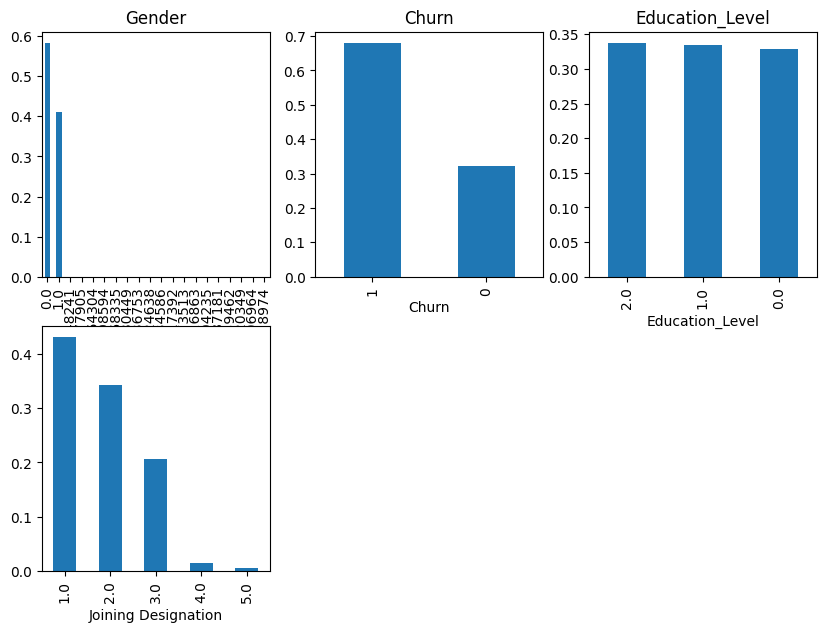

In [69]:

plt.figure(figsize = (10,7))
plt.subplot(231)
df_g['Gender'].value_counts(normalize = True).plot.bar(title = 'Gender')

plt.subplot(232)
df_g['Churn'].value_counts(normalize = True).plot.bar(title = 'Churn')

plt.subplot(233)
df_g['Education_Level'].value_counts(normalize = True).plot.bar(title = 'Education_Level')

plt.subplot(234)
df_g['Joining Designation'].value_counts(normalize = True).plot.bar()


Education level is constant

In [71]:
df_g['Churn'].value_counts()

,count
Churn,
1,1616
0,765


<Axes: xlabel='Time_served'>

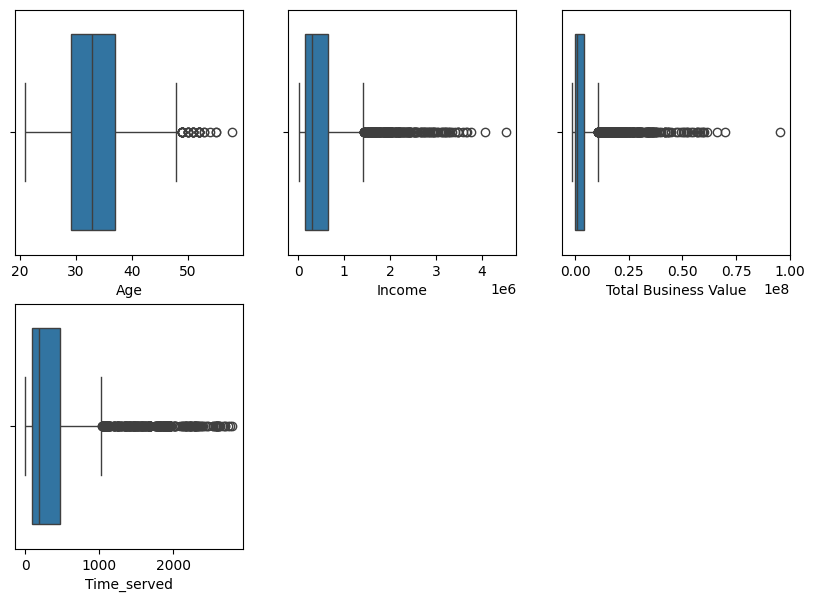

In [70]:
plt.figure(figsize = (10,7))
plt.subplot(231)
sns.boxplot(x = df_g['Age'])

plt.subplot(232)
sns.boxplot(x = df_g['Income'])

plt.subplot(233)
sns.boxplot(x = df_g['Total Business Value'])

plt.subplot(234)
sns.boxplot(x = df_g['Time_served'])

In [75]:
pd.cut(df_g['Income'], bins = [0, 19900, 39900, 49900, 59900, 26990000])
pd.crosstab(df_g[''])

,Income
0,"(59900, 26990000]"
1,"(59900, 26990000]"
2,"(59900, 26990000]"
3,"(59900, 26990000]"
4,"(59900, 26990000]"
...,...
2376,"(59900, 26990000]"
2377,"(19900, 39900]"
2378,"(59900, 26990000]"
2379,"(59900, 26990000]"


High number of outliers in all the fields above


<Axes: >

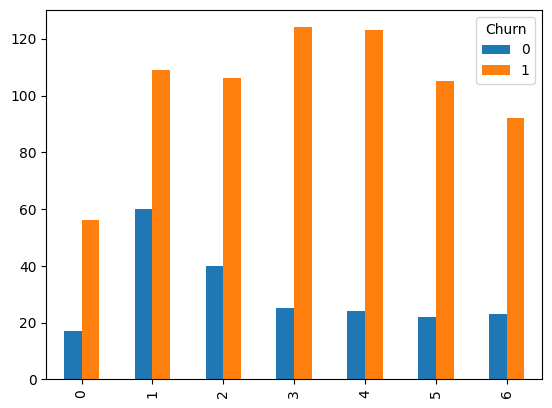

In [76]:
df_g['income_bin'] = pd.cut(df_g['Income'],bins = [10000, 40000, 70000, 100000, 130000, 160000, 190000, 220000])
new = pd.crosstab(df_g['income_bin'],df_g['Churn']).reset_index()
new.plot(kind = 'bar')


<Axes: >

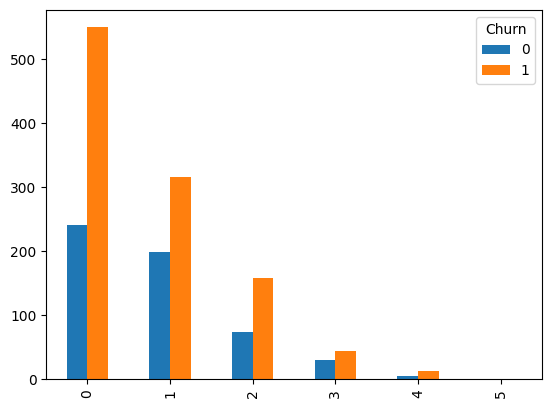

In [78]:
df_g['Age_bin'] = pd.cut(df_g['Age'], bins = [30,35,40,45,50,55,60])
new = pd.crosstab(df_g['Age_bin'], df_g['Churn']).reset_index()
new.plot(kind = 'bar')

In [79]:
df_g.drop(['Age_bin','income_bin'], axis=1, inplace = True)


In [80]:
df_g.corr()

,Driver_ID,Age,Gender,Income,Joining Designation,Total Business Value,Education_Level,City_encoded,Churn,Last_grade,Income_increased,Last_rat,Grade_improved,Rating_change,Time_served
Driver_ID,1.000000,-0.011099,0.012186,0.004593,-0.023126,0.015133,-0.014343,-0.014024,0.029269,-0.013897,-0.015433,0.012889,-0.015433,-0.024964,0.047358
Age,-0.011099,1.000000,0.025746,0.311143,0.071278,0.270087,-0.008743,0.025931,-0.080096,0.248665,0.116373,0.157617,0.116373,-0.049244,0.325145
Gender,0.012186,0.025746,1.000000,0.022150,-0.048711,0.019569,-0.012074,-0.055421,0.009688,-0.003882,0.026449,0.026158,0.026449,0.032494,0.027436
Income,0.004593,0.311143,0.022150,1.000000,0.020500,0.827558,0.059509,0.059538,-0.342665,0.518629,0.244825,0.438986,0.244825,-0.035724,0.753388
Joining Designation,-0.023126,0.071278,-0.048711,0.020500,1.000000,-0.121368,0.003203,0.075969,-0.127773,0.712459,-0.083492,-0.063404,-0.083492,0.197350,-0.218455
Total Business Value,0.015133,0.270087,0.019569,0.827558,-0.121368,1.000000,0.001392,0.072517,-0.379552,0.382062,0.424532,0.544176,0.424532,-0.055802,0.672332
Education_Level,-0.014343,-0.008743,-0.012074,0.059509,0.003203,0.001392,1.000000,-0.001012,-0.007953,-0.017352,-0.024443,0.006544,-0.024443,-0.028638,0.007630
City_encoded,-0.014024,0.025931,-0.055421,0.059538,0.075969,0.072517,-0.001012,1.000000,-0.042236,0.099044,-0.006029,0.029535,-0.006029,0.042722,0.053575
Churn,0.029269,-0.080096,0.009688,-0.342665,-0.127773,-0.379552,-0.007953,-0.042236,1.000000,-0.225585,-0.176845,-0.510532,-0.176845,-0.335918,-0.174236
Last_grade,-0.013897,0.248665,-0.003882,0.518629,0.712459,0.382062,-0.017352,0.099044,-0.225585,1.000000,0.146905,0.120442,0.146905,0.069029,0.335078


<Axes: xlabel='Education_Level', ylabel='count'>

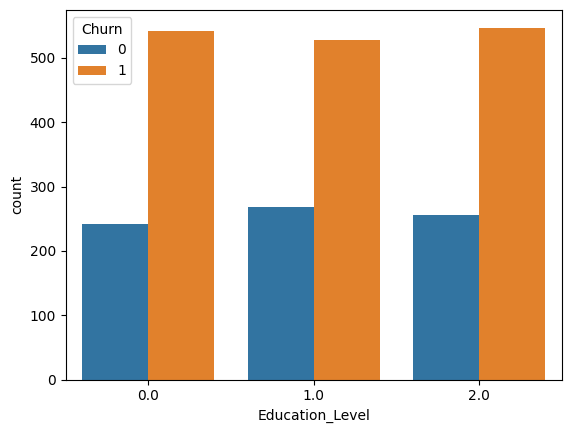

In [81]:
sns.countplot(x = df_g['Education_Level'], hue = df_g['Churn'])

Education level has no impact on churn

In [84]:
df_n = df_g.groupby('Last_rat')['Churn'].value_counts(normalize=True).unstack().reset_index()
df_n.melt(id_vars = 'Last_rat', value_name = 'p', var_name = 'Churn')

,Last_rat,Churn,p
0,1.0,0,0.178899
1,2.0,0,0.596685
2,3.0,0,0.833333
3,4.0,0,0.906542
4,1.0,1,0.821101
5,2.0,1,0.403315
6,3.0,1,0.166667
7,4.0,1,0.093458


In [85]:
df_p = df_g.groupby('Last_rat')['Churn'].value_counts(normalize=True).unstack().reset_index()
df_p_new = df_p.melt(id_vars = 'Last_rat', value_name = 'p', var_name = 'Churn')

<Axes: xlabel='Last_rat', ylabel='p'>

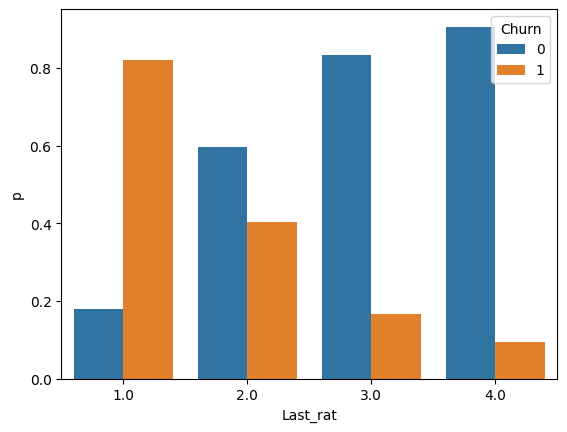

In [86]:
sns.barplot(x = 'Last_rat',y = 'p', hue = 'Churn', data = df_p_new)

almost 80% of drivers having 1 rating at last, have churned. And only 10% of drivers churn if rating is 4

<Axes: xlabel='Rating_change', ylabel='p'>

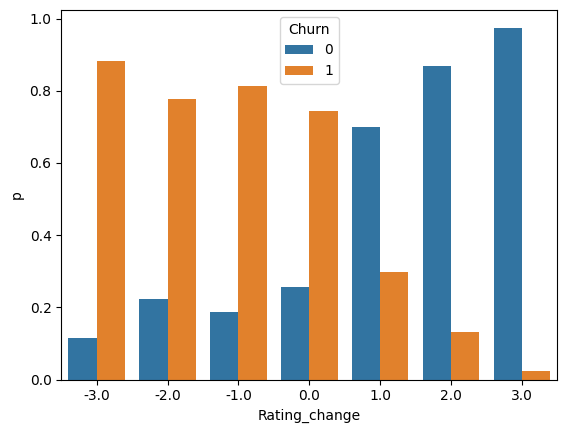

In [87]:
df_g_r = df_g.groupby('Rating_change')['Churn'].value_counts(normalize = True).unstack().reset_index()
df_g_m = df_g_r.melt(id_vars = 'Rating_change', value_name = 'p',var_name = 'Churn')
sns.barplot(x = df_g_m['Rating_change'], y = df_g_m['p'], hue = df_g_m['Churn'])

if rating decreases driver churn is more, if rating increases drive churn is less

<Axes: xlabel='Income_increased', ylabel='p'>

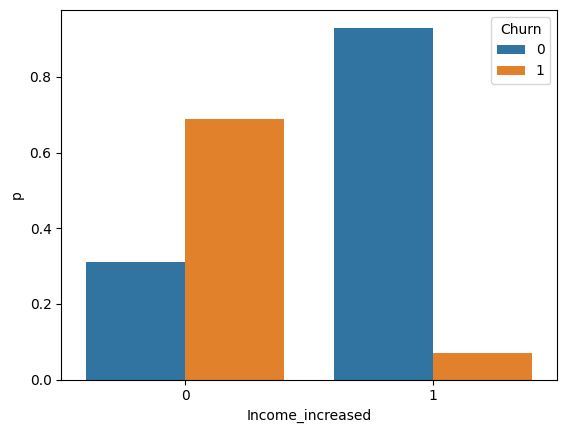

In [88]:
df_g_r = df_g.groupby('Income_increased')['Churn'].value_counts(normalize = True).unstack().reset_index()
df_g_m = df_g_r.melt(id_vars = 'Income_increased', value_name = 'p',var_name = 'Churn')
sns.barplot(x = df_g_m['Income_increased'], y = df_g_m['p'], hue = df_g_m['Churn'])

if income increases, churn is just 5%, and if it does not increasr chutn is 70%

with increasing salary churn rate is decreasing

<Axes: xlabel='Age', ylabel='Count'>

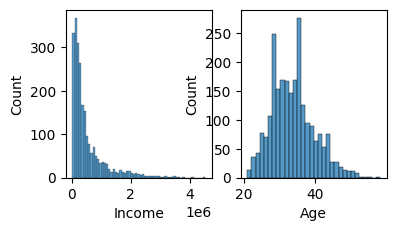

In [91]:
plt.subplot(231)
sns.histplot(df_g['Income'])

plt.subplot(232)
sns.histplot(df_g['Age'])

In [19]:
from scipy.stats import shapiro

stat, p = shapiro(df['Age'].dropna())
print(f"Shapiro-Wilk Test: p-value = {p}")

if p > 0.05:
    print("Data is likely normally distributed (fail to reject H0).")
else:
    print("Data is not normally distributed (reject H0).")

Shapiro-Wilk Test: p-value = 4.947396193019621e-42
Data is not normally distributed (reject H0).


Skewness check

In [22]:
from scipy.stats import skew

skewness = skew(df['Age'].dropna())  # Drop NaN values before calculating
print(f"Skewness: {skewness}")

Skewness: 0.43611316226071467


In [111]:
from scipy.stats import skew

skewness = skew(df['Income'].dropna())  # Drop NaN values before calculating
print(f"Skewness: {skewness}")

Skewness: 0.7059296451167301


All age, income are right skewed

<ipython-input-93-6a4fd314f70f>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_g_r = df_g.groupby('Time_bin')['Churn'].value_counts(normalize = True).unstack().reset_index()


<Axes: xlabel='Time_bin', ylabel='p'>

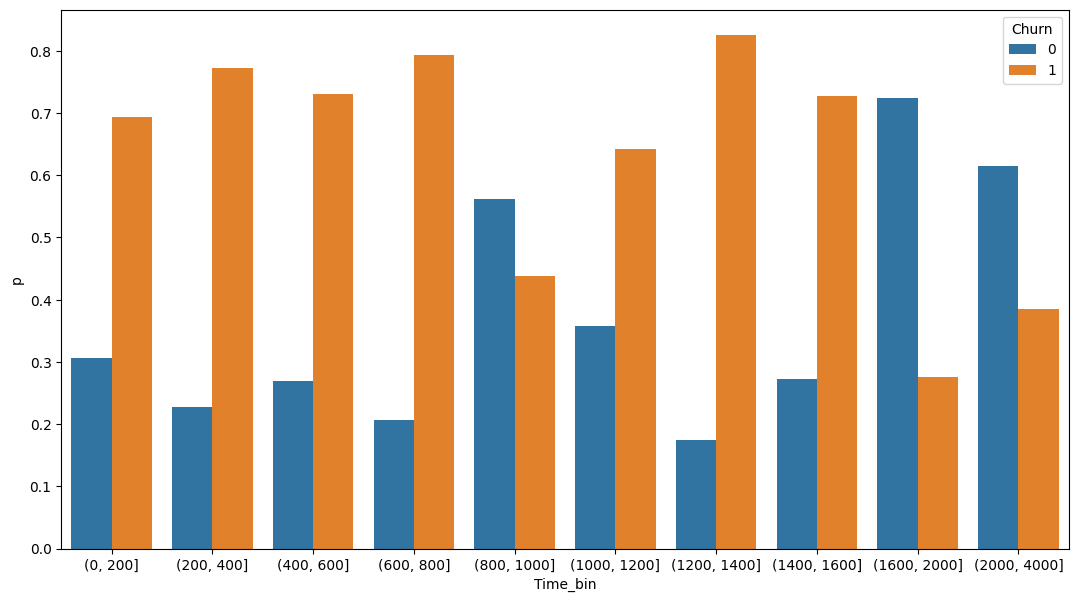

In [93]:
df_g['Time_bin']=pd.cut(df_g['Time_served'], bins = [0,200, 400, 600, 800, 1000, 1200, 1400, 1600,2000,4000])
df_g_r = df_g.groupby('Time_bin')['Churn'].value_counts(normalize = True).unstack().reset_index()
df_g_m = df_g_r.melt(id_vars = 'Time_bin', value_name = 'p',var_name = 'Churn')
plt.figure(figsize = (13,7))
sns.barplot(x = df_g_m['Time_bin'], y = df_g_m['p'], hue = df_g_m['Churn'])

Can not derive much info from time served

problem with gender due to KNN approach. Categorical field

In [94]:
df_g['Gender'] = df_g['Gender'].round().astype(int)

## Build Model

In [441]:
df_g.columns

Index(['Driver_ID', 'Age', 'Gender', 'Income', 'Joining Designation',
       'Total Business Value', 'Education_Level', 'City_encoded', 'Churn',
       'Last_grade', 'Income_increased', 'Last_rat', 'Grade_improved',
       'Rating_change', 'Time_served', 'Time_bin'],
      dtype='object')

In [95]:
X = df_g.drop(['Driver_ID','City_encoded','Time_served','Time_bin','Churn'], axis = 1)
y = df_g['Churn']



---



Scaling

In [96]:
from sklearn.preprocessing import MinMaxScaler

In [97]:
scaler = MinMaxScaler()
X_cols = X.columns
X = scaler.fit_transform(X)

In [98]:
X = pd.DataFrame(X, columns = X_cols)




---
Split data


In [99]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)



---

Balencing
We need balencing as Target is not normally distributed

In [100]:
pip install imbalanced-learn

In [101]:
from imblearn.over_sampling import SMOTE

In [102]:
SMOTE(sampling_strategy = 'auto', random_state = 42)

SMOTE(random_state=42)

In [103]:
smote = SMOTE(sampling_strategy = "auto", random_state = 42)

x_resample, y_resample = smote.fit_resample(x_train, y_train)

# Build Decision Tree

In [104]:
from sklearn.metrics import confusion_matrix, classification_report

In [105]:
from sklearn.tree import DecisionTreeClassifier

In [106]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clft = clf.fit(x_resample,y_resample)

#Predict the response for test dataset
y_pred = clft.predict(x_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.55      0.57      0.56       150
           1       0.80      0.79      0.79       327

    accuracy                           0.72       477
   macro avg       0.68      0.68      0.68       477
weighted avg       0.72      0.72      0.72       477



In [108]:
print(classification_report( y_pred, y_test))

              precision    recall  f1-score   support

           0       0.57      0.55      0.56       154
           1       0.79      0.80      0.79       323

    accuracy                           0.72       477
   macro avg       0.68      0.68      0.68       477
weighted avg       0.72      0.72      0.72       477



In [ ]:
param = ({'ccp_alpha':[7,8,9], 'n_estimators':[67,80]})
rf = RandomForestClassifier()
c= GridSearchCV(rf, param, n_jobs = 1, cv = 3, scoring = 'f1', )

# Random Forest

In [109]:
param = ({'ccp_alpha':[0.01,0.02], 'n_estimators':[100,150]})
rf= RandomForestClassifier()
clf1 = GridSearchCV(rf,param,n_jobs = 1,cv = 3, scoring = 'f1', refit = True)

clf1.fit(x_resample, y_resample)
print(clf1.best_params_)


y_pred = clf1.predict(x_test)


{'ccp_alpha': 0.01, 'n_estimators': 150}


In [502]:
clf1.best_score_

np.float64(0.7829386375457051)

In [503]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65       150
           1       0.83      0.86      0.84       327

    accuracy                           0.78       477
   macro avg       0.75      0.74      0.75       477
weighted avg       0.78      0.78      0.78       477



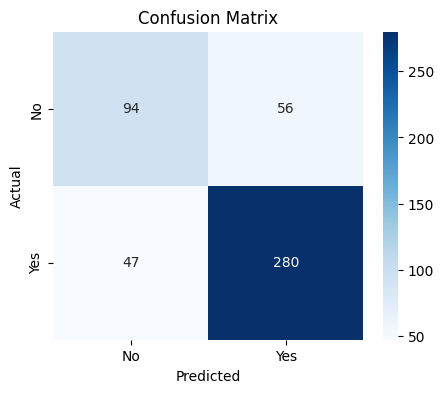

In [504]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#XGBoost

In [124]:
import xgboost as xgb


In [125]:
param = ({'n_estimators':[400],'max_depth':[4,5],  'learning_rate': [0.01],
          'reg_alpha': [0, 0.001, 0.01],
      'reg_lambda': [0, 0.001, 0.01]  })

xgbb = xgb.XGBClassifier()

xg = GridSearchCV(xgbb, param, n_jobs = 1, cv =3, scoring = 'f1')
xg.fit(x_resample, y_resample)
print(xg.best_params_)
print(xg.best_score_)
y_pred = xg.predict(x_test)

print(classification_report(y_test,y_pred))

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 0.01}
0.821170476219269
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       150
           1       0.84      0.86      0.85       327

    accuracy                           0.79       477
   macro avg       0.75      0.74      0.75       477
weighted avg       0.78      0.79      0.78       477



# LightGBM

In [475]:
!pip install lightgbm

In [116]:
import lightgbm as lgb

In [117]:
train_data = lgb.Dataset(x_resample, label=y_resample)
test_data = lgb.Dataset(x_test, label=y_test)
params = {
    'objective': 'binary',  # Change to 'multiclass' if multi-class
    'metric': 'accuracy',
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Trees
    'num_leaves': 31,  # Control tree complexity
    'learning_rate': 0.05,
    'n_estimators': 100,
    'verbose': -1
}

model = lgb.train(params, train_data, valid_sets=[test_data])
y_pred_prob = model.predict(x_test)  # Get probabilities
y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Convert to binary labels
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Accuracy: 0.779874213836478
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       150
           1       0.83      0.85      0.84       327

    accuracy                           0.78       477
   macro avg       0.74      0.74      0.74       477
weighted avg       0.78      0.78      0.78       477



LightGBM gave equially good result with very less time


Out of actual churn count we predicted 86% churn correctly. (recall). and out of our prediction of churn 83% is correct (precision).

as we see random forest gave slightly better recall and precision than xgboost here.

# Feature Importance

In [112]:
pip install shap

In [113]:
import shap

In [118]:
explainer = shap.Explainer(model, x_resample)
shap_values = explainer(x_test)  # SHAP values for test data


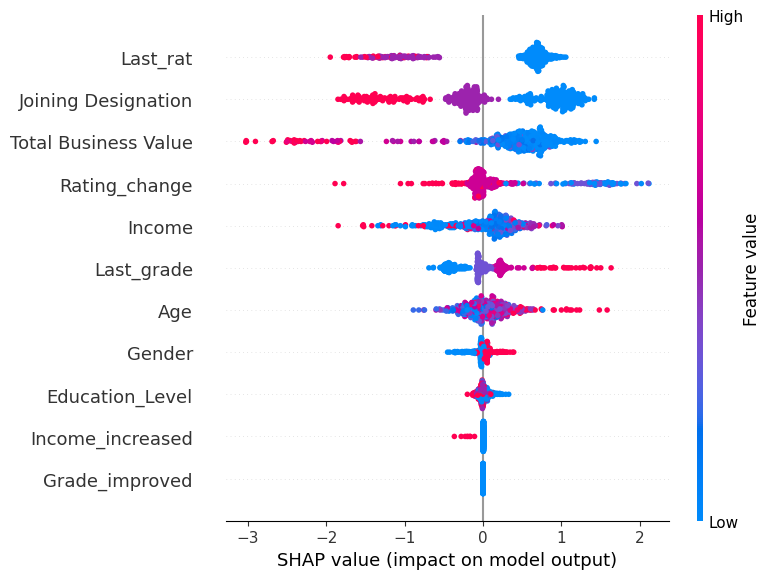

In [120]:
shap.summary_plot(shap_values, x_test)


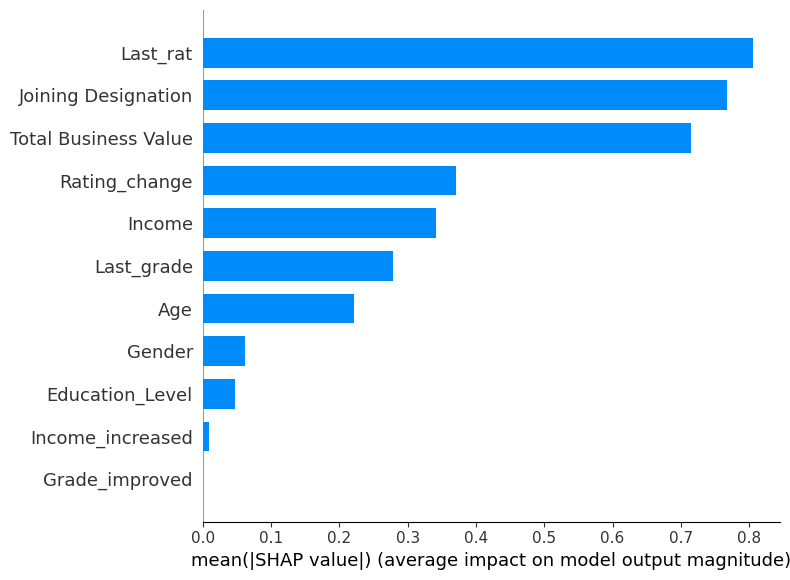

In [123]:
shap.summary_plot(shap_values, x_test, plot_type="bar")


xgb.plot_importance(best_mode) plt.show

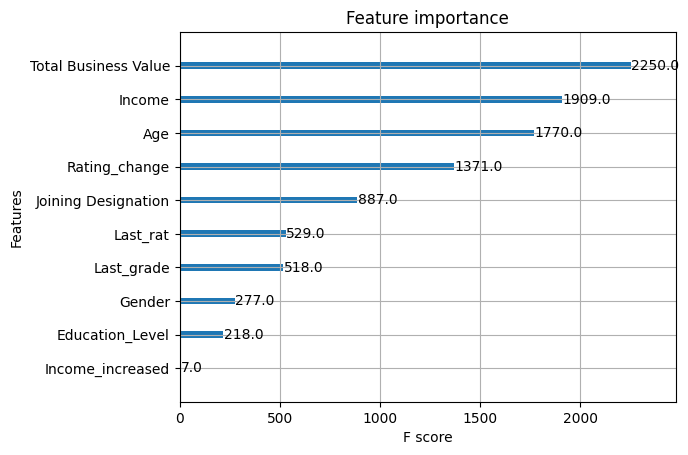

In [126]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get the best model from GridSearchCV
best_model = xg.best_estimator_

# Plot feature importance
xgb.plot_importance(best_model)
plt.show()


In [127]:

feature_importance = best_model.feature_importances_
feature_names = x_resample.columns  # Ensure your dataset has column names

# Create a DataFrame and sort values
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                 Feature  Importance
8               Last_rat    0.596931
3    Joining Designation    0.116320
10         Rating_change    0.059477
4   Total Business Value    0.046343
2                 Income    0.046231
0                    Age    0.035428
6             Last_grade    0.031177
5        Education_Level    0.025922
7       Income_increased    0.021831
1                 Gender    0.020340
9         Grade_improved    0.000000


 92%|==================  | 440/477 [00:15<00:01]       

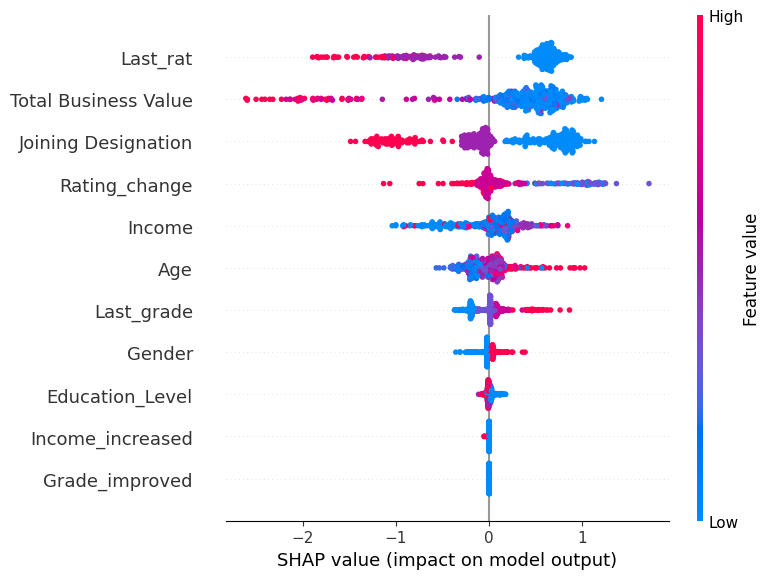

In [128]:
import shap

# Explain the best XGBoost model
explainer = shap.Explainer(best_model, x_resample)
shap_values = explainer(x_test)

# Summary plot (Global Feature Importance)
shap.summary_plot(shap_values, x_test)


Last rating, change in rating, income, Total business value and joining designation has high imporatance in prediction of churn